Tensorflow: Açık kaynak kodlu bir deep learning(derin öğrenme) kütüphanesidir. En büyük özelliği işlemleri birden fazla makineye dağıtabilmesi.
Keras: Keras, Theano veya Tensorflow’u backend olarak kullanır.

In [2]:
#1. Adım: Gerekli Kütüphanelerin Yüklenmesi
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential
from datetime import datetime, date
import datetime
import seaborn as sns
import datetime
import warnings
import lightgbm as lgb
import xgboost as xgb
import plotly.express as px
from typing import Optional, List, Dict
from fbprophet import Prophet
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

D:\Users\200142\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Users\200142\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Users\200142\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Users\200142\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

In [3]:
#2. Adım: Verinin yüklenmesi
fpath = r'D:\Users\200142\Desktop\TEZ\Data\dagitilan_data2.xlsx'
df = pd.read_excel(fpath)

df.shape
df.info()
df.head()
df.isnull().sum()

"""
Veri zaman serisi verisinden oluşmakta olup, saatlik tüketilen enerji değerlerini içermektedir. Görüldüğü gibi veri 'tarih', 'dagitilan', 'sicaklik' isimlerinde olan 3 kolondan ve 53.352 satırdan oluşmaktadır ve boş değer içermemektedir.
Kolonlardaki veri formatları datetime64, float64 ve int64'tür.
""" 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53352 entries, 0 to 53351
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   53352 non-null  datetime64[ns]
 1   dagitilan  53352 non-null  float64       
 2   sicaklik   53352 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.2 MB


"\nVeri zaman serisi verisinden oluşmakta olup, saatlik tüketilen enerji değerlerini içermektedir. Görüldüğü gibi veri 'tarih', 'dagitilan', 'sicaklik' isimlerinde olan 3 kolondan ve 53.352 satırdan oluşmaktadır ve boş değer içermemektedir.\nKolonlardaki veri formatları datetime64, float64 ve int64'tür.\n"

Q1--> 1157.7799699944999
Q3--> 1604.7609064212502
Q2--> 1397.2731202595
Q4--> 2253.161139442
IQR--> 446.9809364267503
Alt sınır: Q1 - 1.5 * IQR---> 487.3085653543744
Üst sınır: Q3 + 1.5 * IQR---> 2275.2323110613756


,datetime,dagitilan,sicaklik
2149,2015-03-31 13:00:00.000,487.308565,14
2091,2015-03-29 03:00:00.000,487.308565,11
10827,2016-03-27 02:59:59.998,487.308565,3
2153,2015-03-31 17:00:00.000,487.308565,15
2152,2015-03-31 16:00:00.000,487.308565,15


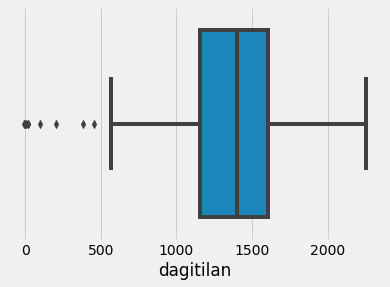

In [4]:
#3. Adım: Aykırı/Uç Değerleri Tespit Etme
df.describe()
sns.boxplot(x=df['dagitilan'])

"""
Veride negatif değerler bulunmaktadır. Ayrıca boxplot grafiği incelenirse; Q1, Q2 ve Q3 değerlerinin sırasıyla 1000-1500, 1500-2000 değerleri arasında hesaplandığı, 
ASD’nin 500'ün altında olduğu ÜSD’nin de 2000'in üzerinde olduğu ve ASD'nin altında değerlerin olduğu görülmektedir.
"""
Q1 = df.dagitilan.quantile(0.25)
Q2 = df.dagitilan.quantile(0.5)
Q3 = df.dagitilan.quantile(0.75)
Q4 = df.dagitilan.quantile(1)
IQR = Q3 - Q1

print("Q1-->", Q1)
print("Q3-->", Q3)
print("Q2-->", Q2)
print("Q4-->", Q4)
print("IQR-->", IQR)
print("Alt sınır: Q1 - 1.5 * IQR--->", Q1 - 1.5 * IQR)
print("Üst sınır: Q3 + 1.5 * IQR--->", Q3 + 1.5 * IQR)

df[df.dagitilan < Q1 - 1.5 * IQR].sort_values('dagitilan')
df.sort_values(['dagitilan'], ascending=True).head(20)

df.loc[(df['dagitilan'] < Q1 - 1.5 * IQR ), 'dagitilan'] = Q1 - 1.5 * IQR
df.sort_values(['dagitilan'], ascending=True).head()


**Verinin Q1, Q2, Q3 değerleri bulunduktan sonra Interquartile range (IQR — Çeyrekler açıklığı) hesaplanır. IQR, birinci çeyrek Q1 ve üçüncü çeyrek Q3 arasındaki uzaklıktır. IQR kullanılarak alt ve üst sınır değerleri aşağıdaki gibi hesaplanır.

IQR = (Q3 – Q1)

Alt Sınır Değer (ASD)= Q1–1.5(IQR)

Üst Sınır Değer (ÜSD)= Q3 + 1.5(IQR)

ASD ve ÜSD dışında kalan tüm değerler outlier (aykırı değer) olarak tespit edilir.

ASD = 487.30 ÜSD = 2275.23

**Grafikte de görüleceği üzere alt sınır değerinin altında olan değerler mevcuttur. Bu değerlere ait günler incelendiğinde 31 Mart 2015 tarihinde Ülke genelinde kesinti olduğu bilgisine ulaşılmıştır. ASD altındaki tüm değerler ASD'ne eşitlenmiştir.

***Index'i değiştirilir ve tarih index olarak atanır.

In [417]:
df = pd.read_excel(fpath, index_col='datetime', parse_dates=['datetime'])
df.head()

,dagitilan,sicaklik
datetime,,
2015-01-01 00:00:00,936.403640,4
2015-01-01 01:00:00,865.697698,4
2015-01-01 02:00:00,787.724599,3
2015-01-01 03:00:00,729.666069,3
2015-01-01 04:00:00,688.746319,4


In [5]:
#boş değer kontrolü
df.isna().sum()

datetime     0
dagitilan    0
sicaklik     0
dtype: int64

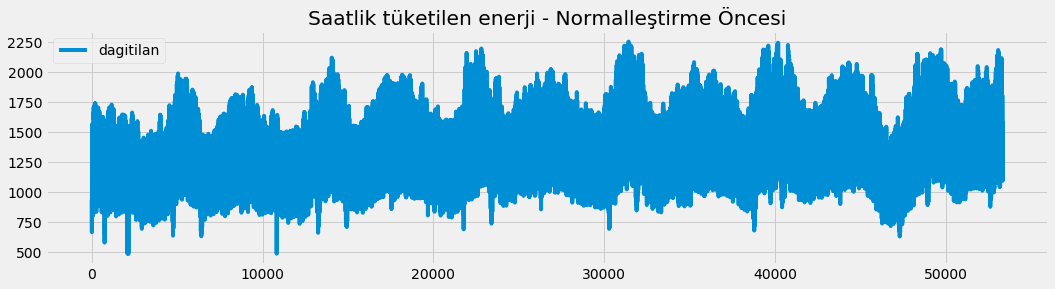

In [6]:
df['dagitilan'].plot(figsize=(16,4),legend=True)

plt.title('Saatlik tüketilen enerji - Normalleştirme Öncesi')

plt.show()

Dağıtılan enerji verisi 0-1 arasında olacak şekilde normalleştirilir. Bunun için sklearn MinMaxScaler kullanılmıştır.

In [7]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['dagitilan'] = scaler.fit_transform(df['dagitilan'].values.reshape(-1,1)) 
    return df

df_norm = normalize_data(df)
df_norm.shape

(53352, 3)

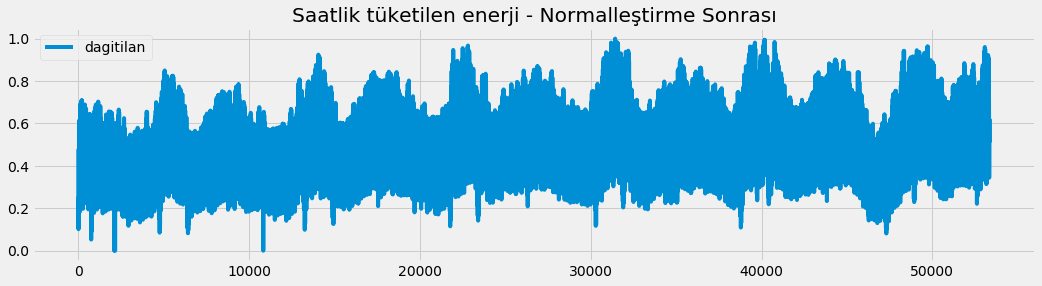

In [8]:
df_norm['dagitilan'].plot(figsize=(16,4),legend=True)

plt.title('Saatlik tüketilen enerji - Normalleştirme Sonrası')

plt.show()

input_shape= (nb_samples, timesteps, input_dim)

In [292]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
        
    #Son 3352 adet veri test için kullanılacak.
    X_test = X_train[50000:]             
    y_test = y_train[50000:]
    
    #ilk 50000 adet veri egitimde kullanılacak.
    X_train = X_train[:50000]           
    y_train = y_train[:50000]
        
    #Numpy dizisine dönüştürülür.
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #RNN modeli için veri tekrar şekillendirilir.
    X_train = np.reshape(X_train, (50000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

# Son 20 saatin değerlerini kullanarak tüketimin tahmin edilmesi


In [423]:
#Egitim ve test data boyutları
seq_len = 20 #kaç birim zamanlık veri verilecek burda onu belirtiyoruz.

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (50000, 20, 1)
y_train.shape =  (50000,)
X_test.shape =  (3332, 20, 1)
y_test.shape =  (3332,)


In [458]:
y_testdf = pd.DataFrame(y_test, columns = ['dagitilan'])


# Basit RNN Modeli Kurulması
3 simpleRNN katmanı oluşturulmuştur. 
ilk katman giriş katmanı 40 çıkışı bulunmaktadır. Kendinden sonraki katmana bağlandığından return_sequences = True değerindedir. 
Giriş katmanı sonrasında  0.15 lik bir Dropout katmanı koyulmuştur. Dropout en basit ifade ile sistemin ezberlemesini önlemeye çalışan bir katmandır. 
İkinci katman ve üçüncü katman da simpleRNN katmanıdır ve 40 çıkışı vardır. Onlardan sonra da yine Dropout eklenmiştir.
Sonda ise çıkış katmanı olarak normal bir YSA katmanı Dense kullanılmıştır. Bir saatin tüketim tahminini vereceği için çıkışı 1'dir.


input_shape= (nb_samples, timesteps, input_dim),
imput_dim = tek bir sayısal değerin değişimi var ise  giriş veri boyutu 1 dir.

LSTM ler  genel anlamda sequence zaman sıralı şekilde gelen veriler üzerinden çalışırlar.
keras.layers.recurrent.LSTM(output_dim,
                                              batch_input_shape=(nb_samples, timesteps, input_dim),
                                              return_sequences=False,....)
(eğer LSTM ilk katmansa batch_input_shape  verilmesi gerekiyor.)
  
nb_samples : veri sayısıdır, None verilebilir. 
timesteps :  LSTM e verilecek veriler zaman bazında değişen aynı türdeki verilerdir ve kaç birim zamanlık veri verilecek ise burada o belirtilmelidir.
input_dim :  giriş verisinin boyutudur.
return_sequences :  Kendinden sonraki katman Yine Bir LSTM olacaksa True  yazılmalıdır.
output_dim :  Katman çıkış boyutu ve LSTM birim sayısıdır.  Ağın çıkışı , eğer kendinden sonraki katman Yine Bir LSTM olacaksa  (nb_samples, timesteps, output_dim), olmayacaksa  (nb_samples, , output_dim) olur.

parametre sayısı = (m * n + n^2 + n) 
m = giriş parametre sayısı
n = çıkış parametre sayısı

1. katman : ( 1 * 40 + 40^2 + 40 = 1680 )
2. ve 3. katman : ( 40 * 40 + 40^2 + 40 = 3240 )
Çıkış katmanı ( 40 ağırlık + 1 bias = 41 )


In [440]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))  

rnn_model.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_89 (SimpleRNN)    (None, 20, 40)            1680      
_________________________________________________________________
dropout_159 (Dropout)        (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_90 (SimpleRNN)    (None, 20, 40)            3240      
_________________________________________________________________
dropout_160 (Dropout)        (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_91 (SimpleRNN)    (None, 40)                3240      
_________________________________________________________________
dropout_161 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)               

Birden fazla girdinin parçalar halinde işlenmesi “mini-batch” olarak adlandırılmaktadır. 
Model tasarlanırken mini-batch parametresi olarak belirlenen değer; modelin aynı anda kaç veriyi işleyeceği anlamına gelmektedir.

Mutlak minimim değerinin bulunması için: Yapay sinir ağlarının optimizasyonu için en çok kullanılan yöntemlerden biri gradyan inişidir (Gradient descent).
Gradyan inişi yöntemini esas alan çeşitli algoritmalar : Rmsprop, Adagrad, Adam, Nadam

In [441]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs = 10, batch_size = 1000)   #epoch = 10, bathc_size = 1000 

Epoch 1/10
50000/50000 [==============================] - 42s 835us/step - loss: 0.1634
Epoch 2/10
50000/50000 [==============================] - 36s 713us/step - loss: 0.0549
Epoch 3/10
50000/50000 [==============================] - 36s 716us/step - loss: 0.0310
Epoch 4/10
50000/50000 [==============================] - 35s 706us/step - loss: 0.0222
Epoch 5/10
50000/50000 [==============================] - 36s 716us/step - loss: 0.0174
Epoch 6/10
50000/50000 [==============================] - 36s 710us/step - loss: 0.0142
Epoch 7/10
50000/50000 [==============================] - 36s 712us/step - loss: 0.0122
Epoch 8/10
50000/50000 [==============================] - 36s 716us/step - loss: 0.0106
Epoch 9/10
50000/50000 [==============================] - 37s 744us/step - loss: 0.0094
Epoch 10/10
50000/50000 [==============================] - 36s 721us/step - loss: 0.0085


In [442]:
rnn_predictions = rnn_model.predict(X_test)
print (X_test[:5,0].T)
print (rnn_predictions[:5,0])

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

[[0.6797174  0.78594415 0.83687323 0.86436566 0.84233444]]
[0.59559643 0.60016346 0.60263306 0.621739   0.6434476 ]
R2 Score of RNN model =  0.8984836149425844


evaluate(), önceden eğitilmiş modeli değerlendirmek içindir. Model için kayıp değerini ve ölçüm değerlerini döndürür.

In [443]:
trainScore = rnn_model.evaluate(X_train, y_train, batch_size = 1000, verbose = 0)
print('Train Score : ', trainScore)
testScore = rnn_model.evaluate(X_test[:252], y_test[:252], batch_size = 1000, verbose = 0)
print('Test Score : ', testScore)

Train Score :  0.001698857273440808
Test Score :  0.0014049176825210452


In [459]:
y_predictions_rnn = pd.DataFrame(rnn_predictions, columns = ['dagitilan'])


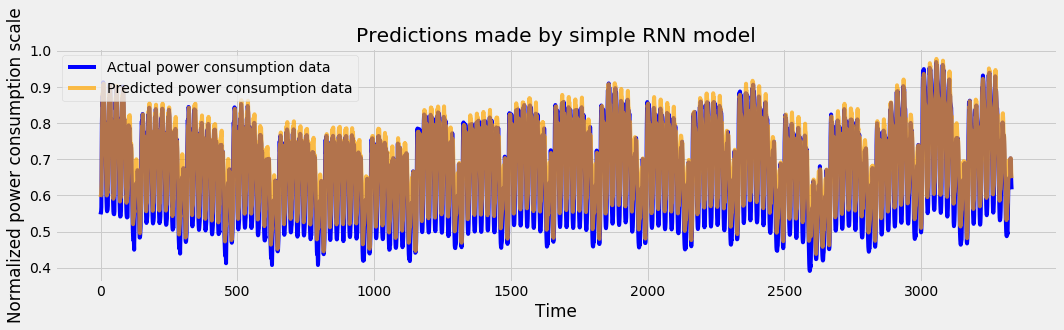

In [445]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

# LSTM Katmanı kurulması
Geleneksel RNN’lerde, tekrarlayan kısımda tek bir tanjant fonksiyonu (katmanı) bulunmaktadır.
LSTM’lerde ise tek bir sinir katmanı yerine tekrarlayan zincir şeklinde dört farklı katman bulunmaktadır. 
Bu nedenle;
parametre sayısı = 4 * (m * n + n^2 + n) 
m = giriş parametre sayısı 
n = çıkış parametre sayısı

1. katman : 4* ( 1 * 40 + 40^2 + 40 = 6720 )
2. ve 3. katman : 4 * ( 40 * 40 + 40^2 + 40 = 12960 ) 
Çıkış katmanı ( 40 ağırlık + 1 bias = 41 )

In [446]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_71 (LSTM)               (None, 20, 40)            6720      
_________________________________________________________________
dropout_162 (Dropout)        (None, 20, 40)            0         
_________________________________________________________________
lstm_72 (LSTM)               (None, 20, 40)            12960     
_________________________________________________________________
dropout_163 (Dropout)        (None, 20, 40)            0         
_________________________________________________________________
lstm_73 (LSTM)               (None, 40)                12960     
_________________________________________________________________
dropout_164 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)               

In [447]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
50000/50000 [==============================] - 101s 2ms/step - loss: 0.0540
Epoch 2/10
50000/50000 [==============================] - 97s 2ms/step - loss: 0.0207
Epoch 3/10
50000/50000 [==============================] - 100s 2ms/step - loss: 0.0195
Epoch 4/10
50000/50000 [==============================] - 99s 2ms/step - loss: 0.0182
Epoch 5/10
50000/50000 [==============================] - 99s 2ms/step - loss: 0.0165
Epoch 6/10
50000/50000 [==============================] - 102s 2ms/step - loss: 0.0135
Epoch 7/10
50000/50000 [==============================] - 100s 2ms/step - loss: 0.0112
Epoch 8/10
50000/50000 [==============================] - 101s 2ms/step - loss: 0.0100
Epoch 9/10
50000/50000 [==============================] - 101s 2ms/step - loss: 0.0092
Epoch 10/10
50000/50000 [==============================] - 102s 2ms/step - loss: 0.0085


In [448]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.7484450861936396


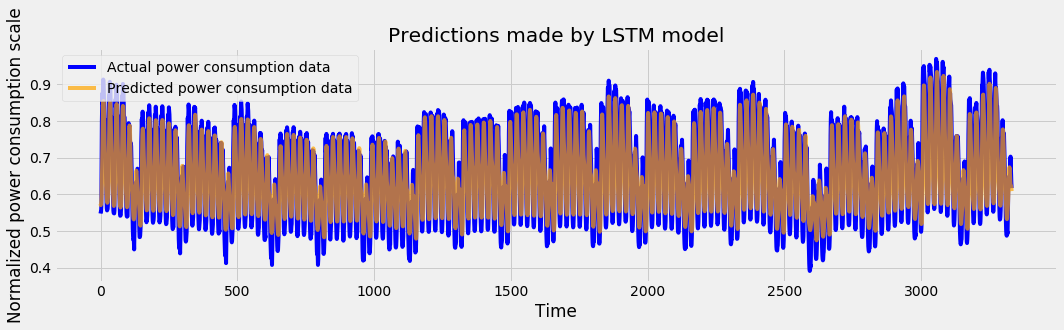

In [449]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

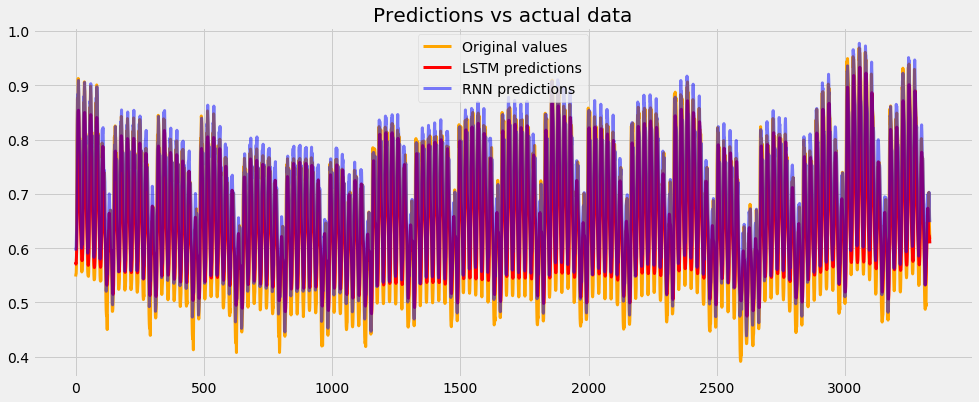

In [450]:
plt.figure(figsize=(15,6))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="blue", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()


In [451]:
y_predictions_lstm = pd.DataFrame(lstm_predictions, columns = ['dagitilan'])
y_predictions_lstm

,dagitilan
0,0.573998
1,0.570601
2,0.573599
3,0.582416
4,0.596314
...,...
3327,0.625343
3328,0.623474
3329,0.623034
3330,0.618239


# Model değerlendirme
Aşağıdaki metrikleri kullanarak zaman serisi tahmin modellerinin performansını değerlendirilir. 
ortalama mutlak hata (MAE), ortalama karesel hata (RMSE), ortalama mutlak yüzde hatası (MAPE) ve sınır ortalama mutlak yüzde hatası (düşük gerçekliğe sahip kayıtları ortadan kaldıran CMAPE). 

In [455]:
def evaluate_forecast_metrics(
    y_true: pd.Series,
    y_pred: pd.Series,
    mape_cutoff: int = 100,
) -> Dict:
 
    # Ortalama Mutlak Hata  (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # Ortalama Kare Hata  (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Ortalama Mutlak Yüzde Hata  (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        
    return {"MAE":round(mae, 3),
            "RMSE":round(rmse, 3),
            "MAPE":round(mape, 3)}
        

In [456]:
rnn_metrics = evaluate_forecast_metrics(y_testdf['dagitilan'], y_predictions_rnn["dagitilan"])
print("RNN evaluate forecast metrics = ", rnn_metrics)
lstm_metrics = evaluate_forecast_metrics(y_testdf['dagitilan'], y_predictions_lstm["dagitilan"])
print("LSTM evaluate forecast metrics = ", lstm_metrics)

RNN evaluate forecast metrics =  {'MAE': 0.035, 'RMSE': 0.04, 'MAPE': 5.694}
LSTM evaluate forecast metrics =  {'MAE': 0.05, 'RMSE': 0.063, 'MAPE': 7.519}


In [457]:
rnn_predictions = rnn_model.predict(X_test)
rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

lstm_predictions = lstm_model.predict(X_test)
lstm_score = r2_score(y_test, lstm_predictions)
print("R2 Score of LSTM model = ",lstm_score)

R2 Score of RNN model =  0.8984836149425844
R2 Score of LSTM model =  0.7484450861936396
